## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.9 MB/s eta 0:00:00


In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Preprocessing 

In [5]:
# remove hashtags
def hashtags(text):
    hash = re.findall(r"#(\w+)", text)
    return hash
    
# remove retweet username and tweeted at @username
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    # remove tweeted at
    return tweet

# remove links
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def clean_html(text):
    html = re.compile('<.*?>')#regex
    return html.sub(r'',text)

# remove non ascii character
def non_ascii(s):
    return "".join(i for i in s if ord(i)<128)

def lower(text):
    return text.lower()

# remove stopwords
def removeStopWords(str):
    #select english stopwords
    cachedStopWords = set(stopwords.words("english"))
    #add custom words
    cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
    #remove stop words
    new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
    return new_str

# remove email address
def email_address(text):
    email = re.compile(r'[\w\.-]+@[\w\.-]+')
    return email.sub(r'',text)

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

# remove digits and special characters
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_(tweet):
    tweet = re.sub('([_]+)', "", tweet)
    return tweet

## Loading the SMS spam collection dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = "/content/drive/MyDrive/[postgrad] S1Y3/NLP/dataset/Project1/"
names = ["class", "sms"]
df = pd.read_csv(path + "SMSSpamCollection.fwf", names=names, sep="\t")
df.sample(10)

,class,sms
3722,ham,Blank is Blank. But wat is blank? Lol
3098,ham,"Yo, you at jp and hungry like a mofo?"
5000,ham,"Hmph. Go head, big baller."
5225,ham,Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!
1548,ham,Bishan lar nearer... No need buy so early cos if buy now i gotta park my car...
103,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
202,ham,Hello darlin ive finished college now so txt me when u finish if u can love Kate xxx
1399,ham,No did you check? I got his detailed message now
10,ham,"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
1608,ham,Jus telling u dat i'll b leaving 4 shanghai on 21st instead so we'll haf more time 2 meet up cya...


## Feature Engineering

In [8]:
df.shape

(5572, 2)

In [9]:
df.isna().sum()

class    0
sms      0
dtype: int64

In [10]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates()
df.shape

(5169, 2)

In [12]:
df = df.dropna()
df.shape

(5169, 2)

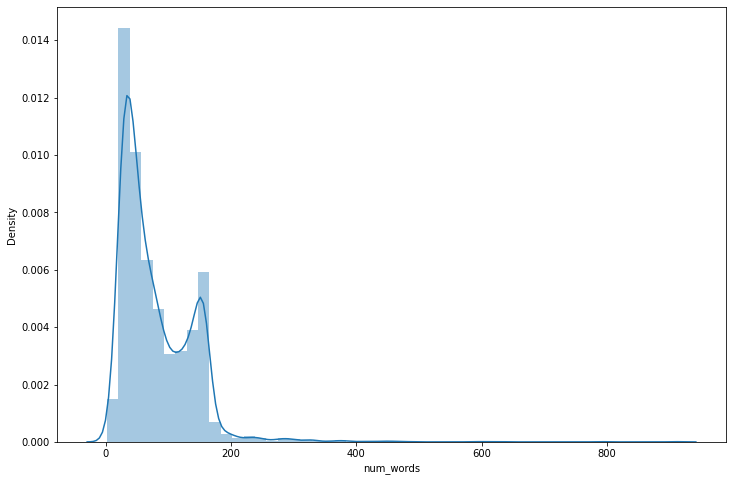

In [13]:
df['num_words'] = df['sms'].apply(len)
sns.distplot(df.num_words);

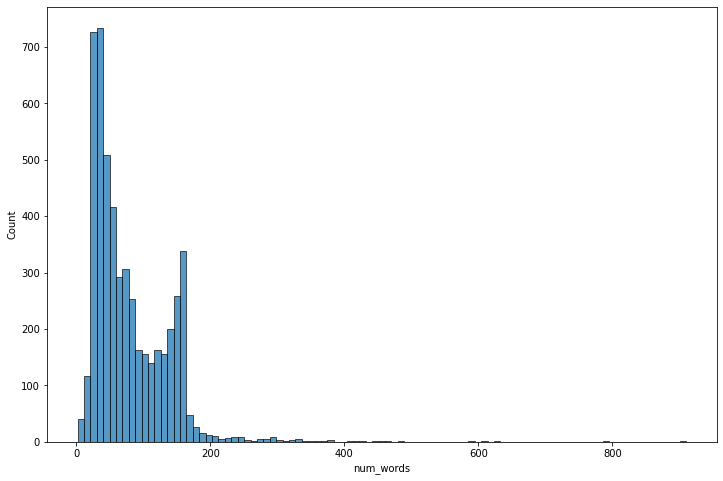

In [14]:
sns.histplot(df.num_words);

In [15]:
print(f"Average number of words in an tweet:{df.num_words.mean():.2f}")

Average number of words in an tweet:79.34


In [16]:
df.num_words.describe()

count    5169.000000
mean       79.344554
std        58.437457
min         2.000000
25%        36.000000
50%        61.000000
75%       119.000000
max       910.000000
Name: num_words, dtype: float64

In [17]:
max_len = 80

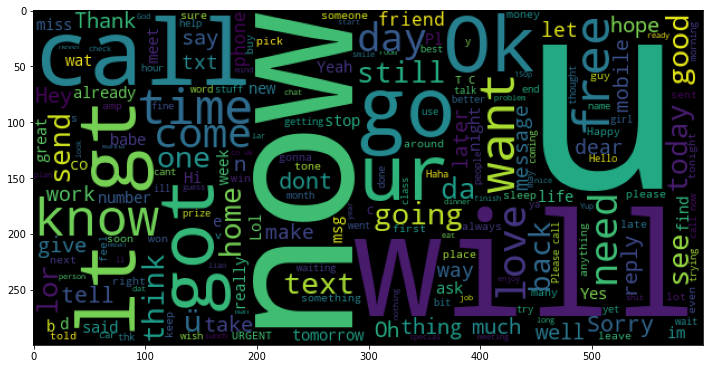

In [18]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df["sms"]))
plt.imshow(wc);

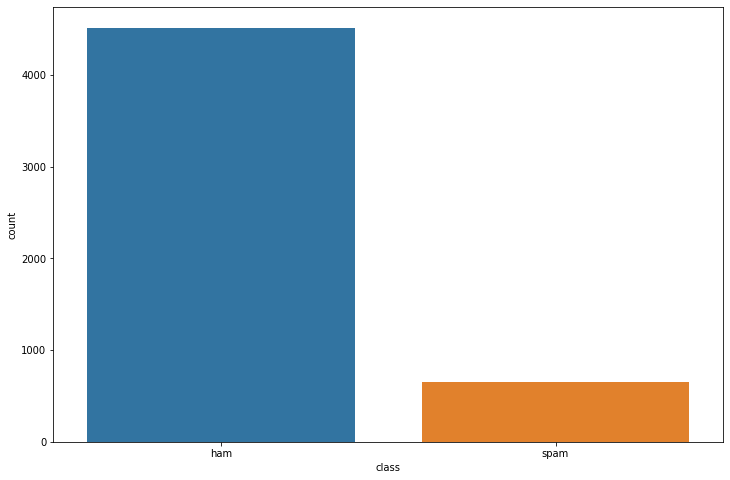

In [19]:
sns.countplot(df["class"])

## Text Preprocessing

In [20]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [21]:
preprocessed_df = text_preprocess(df,'sms')

In [22]:
preprocessed_df.sample(10)

,class,sms,num_words
4107,ham,k marrow coming class,39
2210,ham,hmm well night night,22
5570,ham,the guy bitching acted i d interested buying something else next week gave us free,125
4176,ham,how doing how s queen are going royal wedding,71
251,ham,ranjith cal drpd deeraj deepak min hold,44
4329,spam,congrats mobile g videophones r yours call now videochat wid ur mates play java games dload polyh music noline rentl bx ip we pm,161
5103,ham,in news hassling get weed week andres money haughaighgtujhyguj,98
73,ham,k k where you how performed,42
677,ham,maybe say hi find got card great escape wetherspoons,80
320,ham,coffee cake guess,23


## Splitting the dataset into training and test sets

In [23]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.2,random_state=42,shuffle=True,stratify=preprocessed_df["class"])

In [24]:
train_df.sample(5)

,class,sms,num_words
1428,ham,thing r good thanx got exams in march ive done no revision is fran still with boyf ive gotta interviw exeter bit worried x,126
2268,ham,finish liao u,17
2209,spam,urgent your costa del sol holiday await collection call now toclaim sae tc s pobox stockport skxh cost pm maxmins,159
433,spam,congrats nokia video camera phone call calls cost ppm ave call mins vary mobiles close post bcm ldn wcnxx,157
1694,ham,was gr see message r u leaving congrats dear what school wat r ur plans,96


In [25]:
train_df.shape, test_df.shape 

((4135, 3), (1034, 3))

## Encode `Sentiment` as class

In [26]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df["class"])
y_test = encoder.fit_transform(test_df["class"])

In [27]:
print(y_train[0:5])

[0 0 0 0 0]


## Loading the pretrained Tokenizer class and the pretrained ROBERTA-BASE transformer model

In [28]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta = TFAutoModelForSequenceClassification.from_pretrained("roberta-base",from_pt=True)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Performing text tokenization

In [29]:
X_train = tokenizer(text=train_df["sms"].tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)
X_test = tokenizer(text=test_df["sms"].tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

In [30]:
train_df["sms"][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [31]:
X_train['input_ids'][0]

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([    0,    90,  2095, 44172,   184, 37502,   202,     2,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1],
      dtype=int32)>

In [32]:
X_train['attention_mask'][0]

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

## Fine-tuning the ROBERTA transformer model architecture

In [33]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [47]:
embeddings = roberta(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)

output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)

output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)

output = Dense(units=256,activation='relu')(output)
output = Dropout(0.1)(output)

output = Dense(units=128,activation='relu')(output)
output = Dense(units=2,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

In [48]:
model.layers[2]

## Visualizing the model architecture

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124647170  ['input_ids[0][0]',              
 fication (TFRobertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 2),                                                 
                                 hidden_states=None                                         

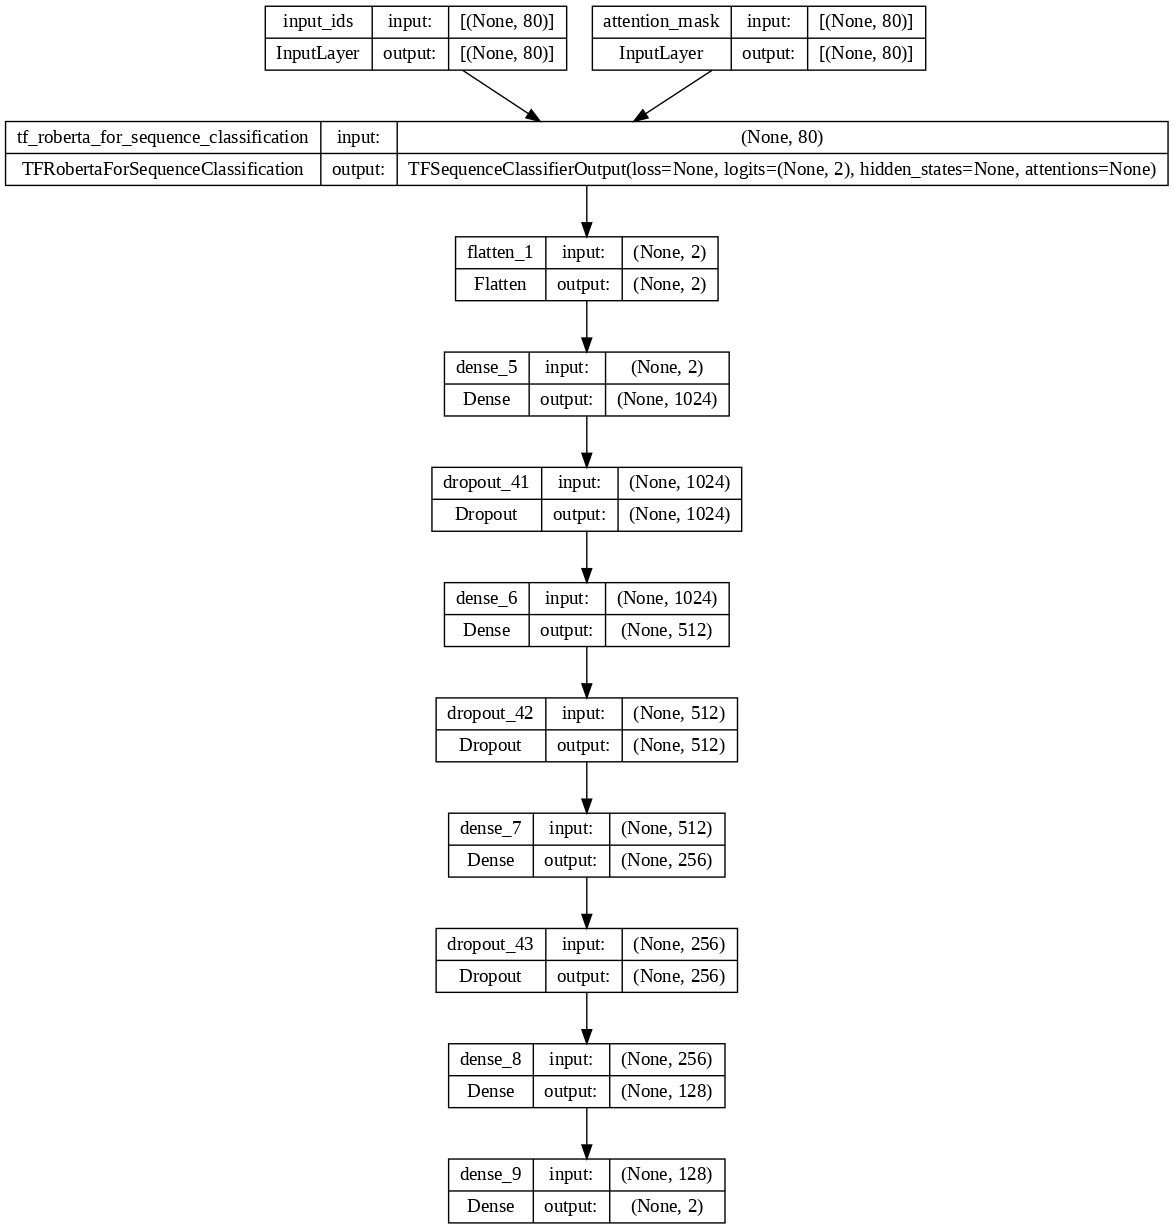

In [50]:
plot_model(model,'ROBERTA-BASE-FINETUNED.png',dpi=100,show_shapes=True)

## Compiling the model

In [51]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,clipnorm=1.0)
loss = CategoricalCrossentropy(from_logits=True)
# metrics = Accuracy(name="accuracy", dtype=None)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

## Training the fine-tuned ROBERTA transformer model

In [52]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=3,
                   verbose=1,
                   mode='max')
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc = ModelCheckpoint(filepath=filepath,
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True,
                     verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=2)

In [53]:
r = model.fit(x={'input_ids': X_train['input_ids'], 
                 'attention_mask': X_train['attention_mask']},
              y=to_categorical(y_train),
              epochs=10,
              batch_size=32,
              callbacks=[es,mc,reduce_lr],
              validation_data=({'input_ids': X_test['input_ids'], 
                                'attention_mask': X_test['attention_mask']},
                               to_categorical(y_test))
             )

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8597
Epoch 1: val_accuracy improved from -inf to 0.87427, saving model to weights-01-0.87.hdf5
130/130 [==============================] - 139s 692ms/step - loss: 0.4086 - accuracy: 0.8597 - val_loss: 0.3781 - val_accuracy: 0.8743 - lr: 5.0000e-05
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8742
Epoch 2: val_accuracy did not improve from 0.87427
130/130 [==============================] - 78s 599ms/step - loss: 0.3838 - accuracy: 0.8742 - val_loss: 0.3801 - val_accuracy: 0.8733 - lr: 5.0000e-05
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8738
Epoch 3: val_accuracy did not improve from 0.87427
130/130 [==============================] - 78s 597ms/step - loss: 0.3805 - accuracy: 0.8738 - val_loss: 0.3804 - val_accuracy: 0.8733 - lr: 5.0000e-05
Epoch 4/10
130/130 [==============================] - ETA: 0s - lo

## Analyzing the overall performance of the fine-tuned ROBERTA transformer model

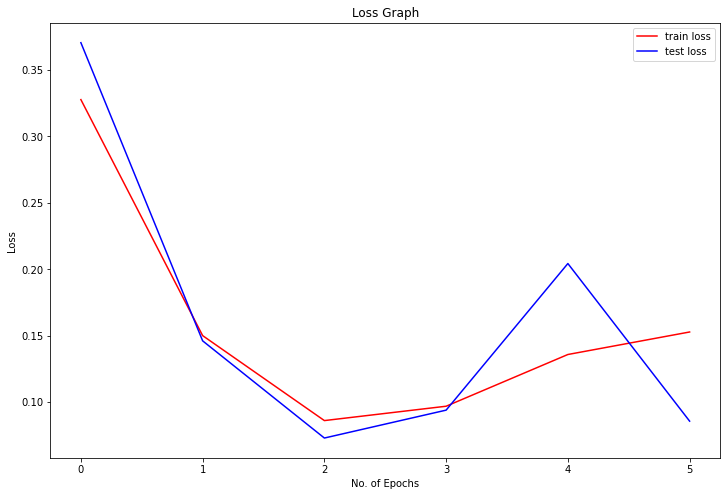

In [41]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

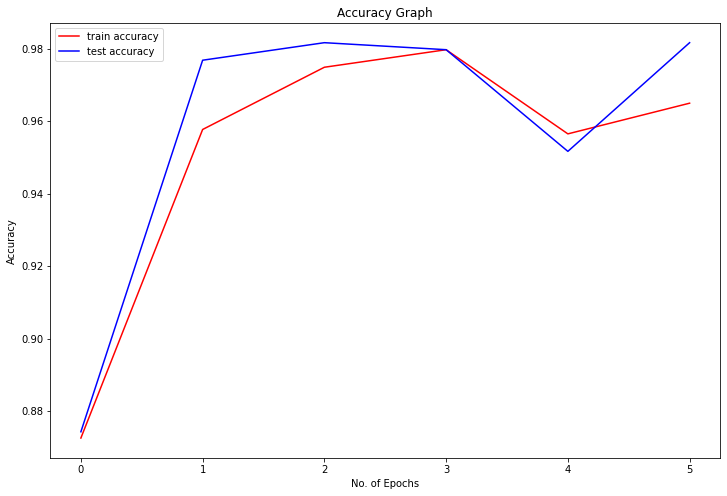

In [42]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'],label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [43]:
model.save(path+'sms_spam_detector.h5')

## Model Evaluation

In [44]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(y_test))
print("Test Categorical Crossentropy Loss:", loss)
print("Test Categorical Accuracy:", acc)

33/33 [==============================] - 6s 171ms/step - loss: 0.0857 - accuracy: 0.9816
Test Categorical Crossentropy Loss: 0.08568017929792404
Test Categorical Accuracy: 0.9816247820854187


In [45]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test,test_predictions))
print("Classification Report:")
print(classification_report(y_test,test_predictions))

33/33 [==============================] - 9s 174ms/step
Confusion Matrix:
[[899   4]
 [ 15 116]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.97      0.89      0.92       131

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

